In [1]:
import json
import pandas as pd
from pathlib import Path
from pprint import pprint
import datetime
import time
import numpy as np
import matplotlib as plt

import pandas
import researchpy as rp
import seaborn as sns

import statsmodels.api as sm
from statsmodels.formula.api import ols
import statsmodels.stats.multicomp

%matplotlib inline

In [2]:
#path_results = Path('/media/discoD/models/elmo/ner/results_20_epochs_ibm')
#path_results = Path('/media/discoD/models/elmo/ner/results_1_epoch_harem_all_combinations')
#path_results = Path('/opt/models/elmo/ner/results (pre queda energia, datalawyer)')
# path_results = Path('/media/discoD/models/elmo/ner/results_embeddings_glove/')
path_results = Path('/media/discoD/models/elmo/ner/mestrado/results_datalawyer/')

In [3]:
for folder in path_results.iterdir():
    print(folder)

/media/discoD/models/elmo/ner/mestrado/results_datalawyer/datalawyer-ft_ELMo+CNN+Embeddings
/media/discoD/models/elmo/ner/mestrado/results_datalawyer/datalawyer-ft_ELMo+Embeddings


In [4]:
configs = dict()
metrics = dict()
for folder in path_results.iterdir():
    results_model_folder = folder.iterdir()
    for training_folder in results_model_folder:
        #print('Reading files from %s' % training_folder.name)
        has_metrics = False
        for results_file in training_folder.iterdir():
            if results_file.name.endswith('.json'):
                #print('Parsing data from %s' % results_file.name)
                if results_file.name.startswith('config'):
                    configs[training_folder.name] = json.loads(results_file.read_bytes())
                elif results_file.name.startswith('metrics.'):
                    metrics[training_folder.name] = json.loads(results_file.read_bytes())
                    has_metrics = True
        if not has_metrics:
            print('"%s"' % training_folder.name)
            del configs[training_folder.name]
print(len(metrics))
print(len(configs))

160
160


In [5]:
def get_seconds(time_str):
    x = time.strptime(time_str.split('.')[0],'%H:%M:%S')
    return datetime.timedelta(hours=x.tm_hour,minutes=x.tm_min,seconds=x.tm_sec).total_seconds()
def get_average_epoch_duration(metrics):
    seconds = get_seconds(metrics['training_duration'])
    training_epochs = metrics['training_epochs'] + 1
    return seconds / training_epochs

In [6]:
TRAINING_ID = 'Training_ID'
SCENARIO = 'Scenario'
MODEL = 'Model'
REPRESENTATION = 'Representation'
EMBEDDING = 'Embedding'
EMBEDDING_TYPE = 'Embedding_Type'
CORPUS_TYPE = 'Corpus_Type'
DOMAIN_SPECIFIC = 'Domain_Specific'
DIMENSION = 'Dimension'
EMBEDDING_DIMENSION = 'Embedding_Dimension'
BATCH_SIZE = 'Batch_Size'
ELMO_DROPOUT = 'ELMo_Dropout'
TRAINING_NUMBER = 'Training_Number'
EXECUTION_NUMBER = 'Execution_Number'
BEST_EPOCH = 'Best_Epoch'
TRAINING_EPOCHS = 'Training_Epochs'
TRAINING_DURATION = 'Training_Duration'
TOTAL_DURATION = 'Total_Duration(s)'
AVERAGE_EPOCH_DURATION = 'Average_Epoch_Duration(s)'
TRAINING_ACCURACY = 'Training_Accuracy'
TRAINING_ACCURACY_TOP3 = 'Training_Accuracy_Top-3'
TRAINING_PRECISION = 'Training_Precision'
TRAINING_RECALL = 'Training_Recall'
TRAINING_F1_MEASURE = 'Training_F1-Measure'
TRAINING_LOSS = 'Training_Loss'
BEST_VALIDATION_ACCURACY = 'Best_Validation_Accuracy'
BEST_VALIDATION_ACCURACY_TOP3 = 'Best_Validation_Accuracy_Top-3'
BEST_VALIDATION_PRECISION = 'Best_Validation_Precision'
BEST_VALIDATION_RECALL = 'Best_Validation_Recall'
BEST_VALIDATION_F1_MEASURE = 'Best_Validation_F1-Measure'
BEST_VALIDATION_LOSS = 'Best_Validation_Loss'
TEST_ACCURACY = 'Test_Accuracy'
TEST_ACCURACY_TOP3 = 'Test_Accuracy_Top-3'
TEST_PRECISION = 'Test_Precision'
TEST_RECALL = 'Test_Recall'
TEST_F1_MEASURE = 'Test_F1_Measure'
TEST_LOSS = 'Test_Loss'
columns = [TRAINING_ID, MODEL, REPRESENTATION, EMBEDDING, CORPUS_TYPE, EMBEDDING_TYPE, DOMAIN_SPECIFIC, DIMENSION, EMBEDDING_DIMENSION, EXECUTION_NUMBER, BEST_EPOCH, TRAINING_EPOCHS, TRAINING_DURATION, TOTAL_DURATION, AVERAGE_EPOCH_DURATION, TRAINING_ACCURACY, TRAINING_ACCURACY_TOP3, TRAINING_PRECISION, TRAINING_RECALL, TRAINING_F1_MEASURE, TRAINING_LOSS, BEST_VALIDATION_ACCURACY, BEST_VALIDATION_ACCURACY_TOP3, BEST_VALIDATION_PRECISION, BEST_VALIDATION_RECALL, BEST_VALIDATION_F1_MEASURE, BEST_VALIDATION_LOSS, TEST_ACCURACY, TEST_ACCURACY_TOP3, TEST_PRECISION, TEST_RECALL, TEST_F1_MEASURE, TEST_LOSS]
columns

['Training_ID',
 'Model',
 'Representation',
 'Embedding',
 'Corpus_Type',
 'Embedding_Type',
 'Domain_Specific',
 'Dimension',
 'Embedding_Dimension',
 'Execution_Number',
 'Best_Epoch',
 'Training_Epochs',
 'Training_Duration',
 'Total_Duration(s)',
 'Average_Epoch_Duration(s)',
 'Training_Accuracy',
 'Training_Accuracy_Top-3',
 'Training_Precision',
 'Training_Recall',
 'Training_F1-Measure',
 'Training_Loss',
 'Best_Validation_Accuracy',
 'Best_Validation_Accuracy_Top-3',
 'Best_Validation_Precision',
 'Best_Validation_Recall',
 'Best_Validation_F1-Measure',
 'Best_Validation_Loss',
 'Test_Accuracy',
 'Test_Accuracy_Top-3',
 'Test_Precision',
 'Test_Recall',
 'Test_F1_Measure',
 'Test_Loss']

In [7]:
def get_training_data_from_id(training_id, config):
    data = training_id.split('_')
    print(data)
    embedding = data[2]
    
    if embedding.startswith('glove'):
        
        if len(data) == 5:
            return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', 
                    DOMAIN_SPECIFIC: False, DIMENSION: data[3][-3:], EXECUTION_NUMBER: data[4],
                    CORPUS_TYPE: 'Nilc'}
        elif len(data) == 7:
            return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', 
                    DOMAIN_SPECIFIC: True, DIMENSION: data[5][-3:], EXECUTION_NUMBER: data[6],
                    CORPUS_TYPE: data[4]}
        elif len(data) == 8:
            return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: 'No', 
                    DOMAIN_SPECIFIC: True, DIMENSION: data[6][-3:], EXECUTION_NUMBER: data[7],
                    CORPUS_TYPE: data[4]}
        else:
            print('Check id: %s' % training_id)
        
    elif embedding.startswith('wang'):
            
        if len(data) == 6:
            return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[3], 
                    DOMAIN_SPECIFIC: False, DIMENSION: data[4][-3:], EXECUTION_NUMBER: data[5], 
                    CORPUS_TYPE: 'Nilc'}
#         elif len(data) == 7:
#             return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[4], 
#                     DOMAIN_SPECIFIC: True, DIMENSION: data[5][-3:], EXECUTION_NUMBER: data[6],
#                     CORPUS_TYPE: data[4]}
        elif len(data) == 8:
            return {MODEL: data[0], REPRESENTATION: data[1], EMBEDDING: data[2], EMBEDDING_TYPE: data[4], 
                    DOMAIN_SPECIFIC: True, DIMENSION: data[6][-3:], EXECUTION_NUMBER: data[7],
                    CORPUS_TYPE: data[5]}
        else:
            print('Check id: %s' % training_id)
            

In [8]:
training_data = []
for training_id, config in configs.items():
    training_metrics = metrics[training_id]
    data = get_training_data_from_id(training_id, config)
    if '-lc' in data[EMBEDDING]:
        data[EMBEDDING] = data[EMBEDDING].replace('-lc', '')
        data[DOMAIN_SPECIFIC] = True
    data[EMBEDDING_DIMENSION] = data[EMBEDDING_TYPE] + '_' + data[DIMENSION]
    data[DOMAIN_SPECIFIC] = 'Sim' if data[DOMAIN_SPECIFIC] else 'Não'
    data[TRAINING_ID] = training_id
    data[BEST_EPOCH] = training_metrics['best_epoch'] if training_metrics else None
    data[TRAINING_EPOCHS] = training_metrics['training_epochs'] + 1 if training_metrics else None
    data[TRAINING_DURATION] = training_metrics['training_duration'] if training_metrics else None
    data[TOTAL_DURATION] = get_seconds(training_metrics['training_duration']) if training_metrics else None
    data[AVERAGE_EPOCH_DURATION] = get_average_epoch_duration(training_metrics) if training_metrics else None
    data[TRAINING_ACCURACY] = training_metrics['training_accuracy'] if training_metrics else None
    data[TRAINING_ACCURACY_TOP3] = training_metrics['training_accuracy3'] if training_metrics else None
    data[TRAINING_PRECISION] = training_metrics['training_precision-overall'] if training_metrics else None
    data[TRAINING_RECALL] = training_metrics['training_recall-overall'] if training_metrics else None
    data[TRAINING_F1_MEASURE] = training_metrics['training_f1-measure-overall'] if training_metrics else None
    data[TRAINING_LOSS] = training_metrics['training_loss'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY] = training_metrics['best_validation_accuracy'] if training_metrics else None
    data[BEST_VALIDATION_ACCURACY_TOP3] = training_metrics['best_validation_accuracy3'] if training_metrics else None
    data[BEST_VALIDATION_PRECISION] = training_metrics['best_validation_precision-overall'] if training_metrics else None
    data[BEST_VALIDATION_RECALL] = training_metrics['best_validation_recall-overall'] if training_metrics else None
    data[BEST_VALIDATION_F1_MEASURE] = training_metrics['best_validation_f1-measure-overall'] if training_metrics else None
    data[BEST_VALIDATION_LOSS] = training_metrics['best_validation_loss'] if training_metrics else None
    data[TEST_ACCURACY] = training_metrics['test_accuracy'] if training_metrics else None
    data[TEST_ACCURACY_TOP3] = training_metrics['test_accuracy3'] if training_metrics else None
    data[TEST_PRECISION] = training_metrics['test_precision-overall'] if training_metrics else None
    data[TEST_RECALL] = training_metrics['test_recall-overall'] if training_metrics else None
    data[TEST_F1_MEASURE] = training_metrics['test_f1-measure-overall'] if training_metrics else None
    data[TEST_LOSS] = training_metrics['test_loss'] if training_metrics else None
    training_data.append(data)

['datalawyer-ft', 'ELMo+CNN+Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '0']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '1']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '2']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '3']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '4']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '5']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '6']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '7']
['datalawyer-ft', 'ELMo+CNN+Embeddings', 'glove-lc', 'jur', '10B-jur2vec-nilc-brwac', 'win-15', 's100', '8']
['datalawyer-ft', '

In [9]:
pd.set_option('display.max_columns', 1000)
training_data_df = pd.DataFrame(training_data, columns=columns)
#training_data_df = training_data_df[(training_data_df[EXECUTION_NUMBER]).astype(int) < 1]
training_data_df

,Training_ID,Model,Representation,Embedding,Corpus_Type,Embedding_Type,Domain_Specific,Dimension,Embedding_Dimension,Execution_Number,Best_Epoch,Training_Epochs,Training_Duration,Total_Duration(s),Average_Epoch_Duration(s),Training_Accuracy,Training_Accuracy_Top-3,Training_Precision,Training_Recall,Training_F1-Measure,Training_Loss,Best_Validation_Accuracy,Best_Validation_Accuracy_Top-3,Best_Validation_Precision,Best_Validation_Recall,Best_Validation_F1-Measure,Best_Validation_Loss,Test_Accuracy,Test_Accuracy_Top-3,Test_Precision,Test_Recall,Test_F1_Measure,Test_Loss
0,datalawyer-ft_ELMo+CNN+Embeddings_glove-lc_jur...,datalawyer-ft,ELMo+CNN+Embeddings,glove,10B-jur2vec-nilc-brwac,No,Sim,100,No_100,0,9,10,0:25:05.229618,1505.0,150.5,0.995505,0.995718,0.949467,0.945135,0.947296,24.399191,0.989258,0.989606,0.913378,0.927159,0.920217,84.798780,0.989247,0.989694,0.912193,0.909455,0.910822,84.599185
1,datalawyer-ft_ELMo+CNN+Embeddings_glove-lc_jur...,datalawyer-ft,ELMo+CNN+Embeddings,glove,10B-jur2vec-nilc-brwac,No,Sim,100,No_100,1,9,10,0:25:00.450945,1500.0,150.0,0.995514,0.995724,0.949319,0.946504,0.947910,24.621428,0.989302,0.989707,0.911704,0.924037,0.917829,84.263426,0.988634,0.988996,0.916582,0.906953,0.911743,85.466005
2,datalawyer-ft_ELMo+CNN+Embeddings_glove-lc_jur...,datalawyer-ft,ELMo+CNN+Embeddings,glove,10B-jur2vec-nilc-brwac,No,Sim,100,No_100,2,9,10,0:25:00.631538,1500.0,150.0,0.995405,0.995605,0.947861,0.947645,0.947753,24.942912,0.990070,0.990374,0.913625,0.924558,0.919059,82.830755,0.988048,0.988466,0.908271,0.906453,0.907361,88.198514
3,datalawyer-ft_ELMo+CNN+Embeddings_glove-lc_jur...,datalawyer-ft,ELMo+CNN+Embeddings,glove,10B-jur2vec-nilc-brwac,No,Sim,100,No_100,3,8,10,0:25:00.009461,1500.0,150.0,0.995827,0.996048,0.951535,0.947302,0.949414,24.069164,0.988881,0.989142,0.907154,0.930281,0.918572,84.289071,0.989080,0.989247,0.912525,0.918459,0.915482,86.332006
4,datalawyer-ft_ELMo+CNN+Embeddings_glove-lc_jur...,datalawyer-ft,ELMo+CNN+Embeddings,glove,10B-jur2vec-nilc-brwac,No,Sim,100,No_100,4,9,10,0:25:03.064172,1503.0,150.3,0.995411,0.995620,0.947152,0.944451,0.945799,24.413442,0.989722,0.990055,0.908858,0.923517,0.916129,81.946353,0.989010,0.989359,0.912044,0.912956,0.912500,86.955644
5,datalawyer-ft_ELMo+CNN+Embeddings_glove-lc_jur...,datalawyer-ft,ELMo+CNN+Embeddings,glove,10B-jur2vec-nilc-brwac,No,Sim,100,No_100,5,9,10,0:25:00.145805,1500.0,150.0,0.995900,0.996142,0.953177,0.949698,0.951434,23.513784,0.989316,0.989591,0.910586,0.921956,0.916236,84.925515,0.988564,0.988913,0.905923,0.910455,0.908184,88.000188
6,datalawyer-ft_ELMo+CNN+Embeddings_glove-lc_jur...,datalawyer-ft,ELMo+CNN+Embeddings,glove,10B-jur2vec-nilc-brwac,No,Sim,100,No_100,6,5,10,0:24:56.883977,1496.0,149.6,0.995548,0.995754,0.950602,0.946048,0.948319,24.663144,0.989432,0.989722,0.908813,0.928200,0.918404,80.889583,0.988466,0.988578,0.902233,0.909455,0.905830,80.508799
7,datalawyer-ft_ELMo+CNN+Embeddings_glove-lc_jur...,datalawyer-ft,ELMo+CNN+Embeddings,glove,10B-jur2vec-nilc-brwac,No,Sim,100,No_100,7,6,10,0:25:04.269821,1504.0,150.4,0.995702,0.995936,0.952048,0.946618,0.949325,24.718463,0.989041,0.989345,0.912865,0.926639,0.919700,82.985968,0.989010,0.989150,0.905284,0.908454,0.906866,76.358969
8,datalawyer-ft_ELMo+CNN+Embeddings_glove-lc_jur...,datalawyer-ft,ELMo+CNN+Embeddings,glove,10B-jur2vec-nilc-brwac,No,Sim,100,No_100,8,6,10,0:24:58.424911,1498.0,149.8,0.995454,0.995623,0.948418,0.943766,0.946087,24.950154,0.988852,0.989055,0.908444,0.929240,0.918724,81.578326,0.988425,0.988578,0.905352,0.913957,0.909634,77.954832
9,datalawyer-ft_ELMo+CNN+Embeddings_glove-lc_jur...,datalawyer-ft,ELMo+CNN+Embeddings,glove,10B-jur2vec-nilc-brwac,No,Sim,100,No_100,9,9,10,0:25:08.038145,1508.0,150.8,0.995265,0.995435,0.946802,0.943995,0.945396,25.057447,0.989345,0.989751,0.911659,0.923517,0.917550,87.592354,0.988913,0.989359,0.909500,0.909955,0.909727,84.025510


In [10]:
training_data_df.to_csv('training_data_10_epochs_embeddings_datalawyer.csv', index=None)

In [11]:
str(datetime.timedelta(seconds=training_data_df[TOTAL_DURATION].mean()))

'0:23:11.818750'

In [12]:
default_exported_columns = ['mean', 'min', 'max', 'std']
renamed_columns = ['Contagem', 'F-Score', 'Desvio Padrão', 'Mínimo', '25%', '50%', '75%', 'Máximo']
exported_columns_names = ['F-Score', 'Mínimo', 'Máximo', 'Desvio Padrão']
model_map = {'datalawyer-ft': 'Sim', 'datalawyer': 'Não', 'datalawyer-pt': 'Geral'}
representation_map = {'ELMo+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo+Embeddings': 'ELMo+Vetor', 'ELMo-pt+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo-pt+Embeddings': 'ELMo+Vetor', 'ELMo-pt': 'ELMo', 'ELMo-pt+CNN': 'ELMo+CNN'}
embedding_type_map = {'skip': 'Skip-Gram', 'No': 'Sem Tipo', 'cbow': 'CBoW'}
embedding_map = {'wang2vec': 'Wang2Vec', 'glove': 'GloVe', 'word2vec': 'Word2Vec', 'No': 'Sem Vetor', 'fasttext': 'FastText', 'wang2vec-lc': 'Wang2Vec', 'glove-lc': 'GloVe', 'word2vec-lc': 'Word2Vec', 'fasttext-lc': 'FastText'}
replacements_map = {**model_map, **representation_map, **embedding_type_map, **embedding_map}

def get_group_csv(index_names, group_name, group_columns, target_value, index_map, dataframe=training_data_df, exported_columns=default_exported_columns):
    dataframe = dataframe.rename(index={'ELMo-pt+CNN+Embeddings': 'ELMo+CNN+Vetor', 'ELMo-pt+Embeddings': 'ELMo+Vetor', 'ELMo-pt': 'ELMo', 'ELMo-pt+CNN': 'ELMo+CNN'})
    if type(index_names) == str:
        index_names = [index_names]
    group = dataframe.groupby(group_columns).describe()[target_value].sort_values(by='mean', ascending=False)
    for column in exported_columns:
        group[column] = group[column] * 100
    group.index.names = index_names
    group = group.rename(index=index_map)
    group.columns = renamed_columns
    group.to_csv('grupo_' + group_name + '_10_epochs_embeddings_datalawyer.csv', columns=exported_columns_names, float_format = '%.2f%%')
    return group

In [13]:
get_group_csv('Ajuste Fino', DOMAIN_SPECIFIC, DOMAIN_SPECIFIC, TEST_F1_MEASURE, model_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Ajuste Fino,,,,,,,,
Sim,80.0,91.182630,0.334264,90.319361,0.909520,0.911614,0.914036,91.917671
Não,80.0,91.153001,0.390708,90.336858,0.908886,0.911186,0.914798,91.940748


In [14]:
get_group_csv('Tipo de Vetor', EMBEDDING_TYPE, EMBEDDING_TYPE, TEST_F1_MEASURE, embedding_type_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Tipo de Vetor,,,,,,,,
Sem Tipo,80.0,91.220492,0.371529,90.319361,0.909829,0.911691,0.915316,91.940748
Skip-Gram,80.0,91.115139,0.348103,90.336858,0.909045,0.911094,0.913406,91.883768


In [15]:
get_group_csv('Dimensão', DIMENSION, DIMENSION, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Dimensão,,,,,,,,
300,80.0,91.276381,0.351977,90.319361,0.909828,0.912597,0.915455,91.940748
100,80.0,91.059251,0.342155,90.336858,0.908138,0.910817,0.912587,91.883768


In [16]:
get_group_csv('Vetor', EMBEDDING, EMBEDDING, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Vetor,,,,,,,,
GloVe,80.0,91.220492,0.371529,90.319361,0.909829,0.911691,0.915316,91.940748
Wang2Vec,80.0,91.115139,0.348103,90.336858,0.909045,0.911094,0.913406,91.883768


In [17]:
get_group_csv('Corpus', CORPUS_TYPE, CORPUS_TYPE, TEST_F1_MEASURE, embedding_map)

,Contagem,F-Score,Desvio Padrão,Mínimo,25%,50%,75%,Máximo
Corpus,,,,,,,,
10B-jur2vec-nilc-brwac,80.0,91.182630,0.334264,90.319361,0.909520,0.911614,0.914036,91.917671
Nilc,80.0,91.153001,0.390708,90.336858,0.908886,0.911186,0.914798,91.940748


In [18]:
get_group_csv(['Vetor', 'Domínio Específico'], 'Emb_Dom', [EMBEDDING, DOMAIN_SPECIFIC], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  Desvio Padrão     Mínimo  \
Vetor    Domínio Específico                                                  
GloVe    Não                     40.0  91.232533       0.394877  90.435223   
         Sim                     40.0  91.208452       0.351257  90.319361   
Wang2Vec Sim                     40.0  91.156808       0.318717  90.413016   
         Não                     40.0  91.073470       0.374588  90.336858   

                                  25%       50%       75%     Máximo  
Vetor    Domínio Específico                                           
GloVe    Não                 0.909455  0.911806  0.915574  91.940748  
         Sim                 0.910033  0.911691  0.914367  91.917671  
Wang2Vec Sim                 0.909114  0.911336  0.913495  91.883768  
         Não                 0.908886  0.911044  0.912727  91.832119

In [19]:
get_group_csv(['Ajuste Fino', 'Vetor', 'Corpus', 'Dimensão'], 'Dom_Emb_Cor_Dim', [DOMAIN_SPECIFIC,EMBEDDING,CORPUS_TYPE,DIMENSION], TEST_F1_MEASURE, replacements_map)

Contagem    F-Score  \
Ajuste Fino Vetor    Corpus                 Dimensão                        
Não         GloVe    Nilc                   300           20.0  91.389366   
Sim         GloVe    10B-jur2vec-nilc-brwac 300           20.0  91.295958   
Não         Wang2Vec Nilc                   300           20.0  91.254403   
Sim         Wang2Vec 10B-jur2vec-nilc-brwac 300           20.0  91.165795   
                                            100           20.0  91.147822   
            GloVe    10B-jur2vec-nilc-brwac 100           20.0  91.120946   
Não         GloVe    Nilc                   100           20.0  91.075699   
            Wang2Vec Nilc                   100           20.0  90.892538   

                                                      Desvio Padrão  \
Ajuste Fino Vetor    Corpus                 Dimensão                  
Não         GloVe    Nilc                   300            0.387204   
Sim         GloVe    10B-jur2vec-nilc-brwac 300            0.362010   
Não         Wang2Vec Nilc                   300            0.320211   
Sim         Wang2Vec 10B-jur2vec-nilc-brwac 300            0.323076   
                                            100            0.322427   
            GloVe    10B-jur2vec-nilc-brwac 100            0.325706   
Não         GloVe    Nilc                   100            0.344026   
            Wang2Vec Nilc                   100            0.341413   

                                                         Mínimo       25%  \
Ajuste Fino Vetor    Corpus                 Dimensão                        
Não         GloVe    Nilc                   300       90.611028  0.910820   
Sim         GloVe    10B-jur2vec-nilc-brwac 300       90.319361  0.911157   
Não         Wang2Vec Nilc                   300       90.701144  0.909702   
Sim         Wang2Vec 10B-jur2vec-nilc-brwac 300       90.714995  0.909091   
                                            100       90.413016  0.909726   
            GloVe    10B-jur2vec-nilc-brwac 100       90.582960  0.909271   
Não         GloVe    Nilc                   100       90.435223  0.907954   
            Wang2Vec Nilc                   100       90.336858  0.906296   

                                                           50%       75%  \
Ajuste Fino Vetor    Corpus                 Dimensão                       
Não         GloVe    Nilc                   300       0.914851  0.916938   
Sim         GloVe    10B-jur2vec-nilc-brwac 300       0.913081  0.915455   
Não         Wang2Vec Nilc                   300       0.911847  0.914798   
Sim         Wang2Vec 10B-jur2vec-nilc-brwac 300       0.911639  0.913079   
                                            100       0.911000  0.913517   
            GloVe    10B-jur2vec-nilc-brwac 100       0.910817  0.913366   
Não         GloVe    Nilc                   100       0.910791  0.913587   
            Wang2Vec Nilc                   100       0.909774  0.911523   

                                                         Máximo  
Ajuste Fino Vetor    Corpus                 Dimensão             
Não         GloVe    Nilc                   300       91.940748  
Sim         GloVe    10B-jur2vec-nilc-brwac 300       91.917671  
Não         Wang2Vec Nilc                   300       91.832119  
Sim         Wang2Vec 10B-jur2vec-nilc-brwac 300       91.798345  
                                            100       91.883768  
            GloVe    10B-jur2vec-nilc-brwac 100       91.809808  
Não         GloVe    Nilc                   100       91.620672  
            Wang2Vec Nilc                   100       91.556663

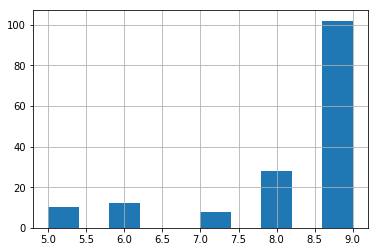

In [20]:
training_data_df[BEST_EPOCH].hist()

In [21]:
training_data_df[TOTAL_DURATION].describe()

count     160.000000
mean     1391.818750
std       112.285176
min      1268.000000
25%      1279.750000
50%      1392.500000
75%      1503.250000
max      1525.000000
Name: Total_Duration(s), dtype: float64

In [22]:
training_data_df.groupby([EXECUTION_NUMBER]).describe()[TEST_F1_MEASURE].sort_values(by='mean', ascending=False)

,count,mean,std,min,25%,50%,75%,max
Execution_Number,,,,,,,,
1,16.0,0.912822,0.003314,0.904130,0.911444,0.913722,0.915015,0.916960
5,16.0,0.912526,0.004061,0.906740,0.909001,0.912038,0.916006,0.918098
9,16.0,0.911943,0.004269,0.903194,0.910127,0.912277,0.914085,0.919177
2,16.0,0.911833,0.003710,0.905847,0.909784,0.911295,0.914983,0.917983
4,16.0,0.911787,0.003303,0.908000,0.909079,0.911621,0.913018,0.918362
8,16.0,0.911314,0.003209,0.906653,0.908717,0.911000,0.913274,0.917942
0,16.0,0.911265,0.003696,0.903369,0.910346,0.911069,0.911517,0.919407
6,16.0,0.911158,0.003386,0.903851,0.909976,0.911086,0.912426,0.916750
3,16.0,0.911137,0.003814,0.906110,0.908671,0.909703,0.914279,0.918838


In [23]:
rp.summary_cont(training_data_df[TEST_F1_MEASURE])

,Variable,N,Mean,SD,SE,95% Conf.,Interval
0,Test_F1_Measure,160.0,0.911678,0.003627,0.000287,0.911112,0.912245


In [24]:
rp.summary_cont(training_data_df.groupby(EMBEDDING))[TEST_F1_MEASURE]

,N,Mean,SD,SE,95% Conf.,Interval
Embedding,,,,,,
glove,80,0.912205,0.003715,0.000415,0.911391,0.913019
wang2vec,80,0.911151,0.003481,0.000389,0.910389,0.911914


In [25]:
# Calculating effect size
def anova_table(aov):
    aov['mean_sq'] = aov[:]['sum_sq']/aov[:]['df']
    
    aov['eta_sq'] = aov[:-1]['sum_sq']/sum(aov['sum_sq'])
    
    aov['omega_sq'] = (aov[:-1]['sum_sq']-(aov[:-1]['df']*aov['mean_sq'][-1]))/(sum(aov['sum_sq'])+aov['mean_sq'][-1])
    
    cols = ['sum_sq', 'mean_sq', 'df', 'F', 'PR(>F)', 'eta_sq', 'omega_sq']
    aov = aov[cols]
    return aov

def print_anova(parameter):
    # Fits the model with the interaction term
    # This will also automatically include the main effects for each factor
    model = ols('Test_F1_Measure ~ C({0})'.format(parameter), training_data_df).fit()
    # Seeing if the overall model is significant
    print(f"Overall model F({model.df_model: .0f},{model.df_resid: .0f}) = {model.fvalue: .3f}, p = {model.f_pvalue: .20f}")
    print(model.summary())
    res = sm.stats.anova_lm(model, typ= 2)
    print(res)
    print(anova_table(res))
    mc = statsmodels.stats.multicomp.MultiComparison(training_data_df[TEST_F1_MEASURE], training_data_df[parameter])
    mc_results = mc.tukeyhsd()
    print(mc_results)

In [26]:
print_anova(EMBEDDING_DIMENSION)

Overall model F( 3, 156) =  6.610, p =  0.00031158789631447961
                            OLS Regression Results                            
Dep. Variable:        Test_F1_Measure   R-squared:                       0.113
Model:                            OLS   Adj. R-squared:                  0.096
Method:                 Least Squares   F-statistic:                     6.610
Date:                Sun, 29 Sep 2019   Prob (F-statistic):           0.000312
Time:                        11:47:46   Log-Likelihood:                 682.12
No. Observations:                 160   AIC:                            -1356.
Df Residuals:                     156   BIC:                            -1344.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------